# FIFA Player Tier Classifier

In this study, we will be looking into soccer player ratings according to EA Sports FC from FIFA 15 to EA Sports FC 24. The dataset is originally scraped from sofifa.com.

We utilized files provided in this link: https://www.kaggle.com/datasets/stefanoleone992/ea-sports-fc-24-complete-player-dataset/data

Our goal is to build a classifier to predict the tier of players based on in-game overall score.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [4]:
male_ratings = pd.read_csv("male_players.csv")
male_ratings.head()

C:\Users\danny\AppData\Local\Temp\ipykernel_51740\1770813449.py:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  male_ratings = pd.read_csv("male_players.csv")


,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,2023-09-22,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3


In [3]:
female_ratings = pd.read_csv("female_players.csv")
female_ratings.head()

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,227203,/player/227203/alexia-putellas-segura/240002,24.0,2.0,2023-09-22,Alexia Putellas,Alexia Putellas Segura,"CM, LW",91,91,...,83+3,83+3,83+3,82+3,80+3,76+3,76+3,76+3,80+3,23+3
1,241667,/player/241667/aitana-bonmati-conca/240002,24.0,2.0,2023-09-22,Aitana Bonmatí,Aitana Bonmatí Conca,CM,90,92,...,83+3,83+3,83+3,81+3,79+3,75+3,75+3,75+3,79+3,21+3
2,227102,/player/227102/caroline-graham-hansen/240002,24.0,2.0,2023-09-22,C. Hansen,Caroline Graham Hansen,RW,90,90,...,68+3,68+3,68+3,71+3,67+3,60+3,60+3,60+3,67+3,20+3
3,227125,/player/227125/sam-kerr/240002,24.0,2.0,2023-09-22,S. Kerr,Samantha May Kerr,ST,90,90,...,62+3,62+3,62+3,64+3,61+3,58+3,58+3,58+3,61+3,20+3
4,236479,/player/236479/maria-pilar-leon-cebrian/240002,24.0,2.0,2023-09-22,Mapi León,María Pilar León Cebrián,CB,89,90,...,86+3,86+3,86+3,85+3,86+3,88+2,88+2,88+2,86+3,20+3


Check if both male_ratings and female_ratings have the same column names. Afterwards, we can join the table.

In [10]:
sum(male_ratings.columns == female_ratings.columns) == male_ratings.shape[1]

True

In [27]:
ratings=pd.concat([male_ratings, female_ratings], axis=0, ignore_index=True)
ratings.head()

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,9/22/2023,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,9/22/2023,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,9/22/2023,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,9/22/2023,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,9/22/2023,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3


We will look into several quantifiable features that are closely related with skill traits as a soccer player. Features are listed below:

In [40]:
features = ["overall",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "attacking_volleys",
    "skill_dribbling",
    "skill_curve",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_agility",
    "movement_reactions",
    "movement_balance",
    "power_shot_power",
    "power_jumping",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_interceptions",
    "mentality_positioning",
    "mentality_vision",
    "mentality_penalties",
    "mentality_composure",
    "defending_marking_awareness",
    "defending_standing_tackle",
    "defending_sliding_tackle",
    "goalkeeping_diving",
    "goalkeeping_handling",
    "goalkeeping_kicking",
    "goalkeeping_positioning",
    "goalkeeping_reflexes"
]

In [41]:
ratings = ratings.loc[:,features]

In [42]:
clean_ratings = ratings.dropna()
clean_ratings

,overall,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,...,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,91,97.0,90.0,80.0,92.0,36.0,78.0,78,94,73,...,84,88.0,26,34,32,13,5,7,11,6
1,91,89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,...,84,87.0,38,47,29,7,14,13,11,7
2,91,72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,...,83,88.0,66,70,53,15,13,5,10,13
3,90,80.0,87.0,90.0,94.0,33.0,64.0,83,89,60,...,75,96.0,20,35,24,6,11,15,14,8
4,90,79.0,88.0,83.0,87.0,39.0,78.0,75,91,90,...,85,90.0,43,24,18,13,11,5,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184779,65,60.0,48.0,41.0,51.0,65.0,71.0,37,41,63,...,46,72.0,65,69,62,5,8,12,13,9
184781,64,78.0,60.0,57.0,61.0,25.0,48.0,62,62,60,...,73,53.0,16,22,18,5,7,9,10,11
184782,63,75.0,63.0,49.0,66.0,38.0,61.0,59,66,44,...,64,44.0,45,37,34,10,9,6,12,8
184783,62,60.0,60.0,43.0,54.0,20.0,70.0,37,65,71,...,68,54.0,15,11,12,11,7,15,13,13


We will visualize the distribution of the ratings of players. We will also group the ratings based on the game's tier: Bronze, Silver, and Gold. We are also interested to group the top 0.1% of the ratings which we will call the "Platinum" tier for these players.

In [ ]:
# Find "Platinum" tier cutoff for the top 0.1% players
cutoff = clean_ratings['overall'].quantile(1- 0.001)

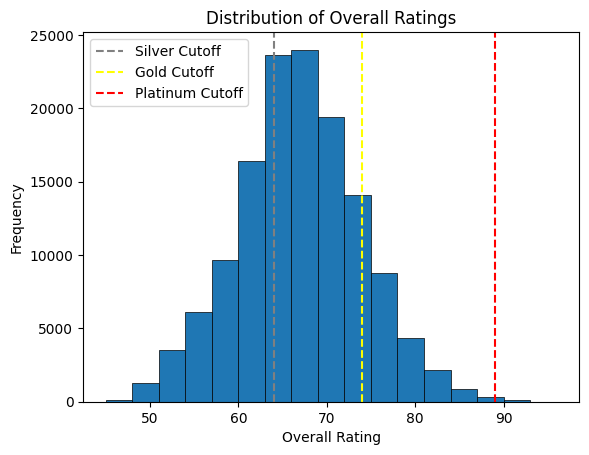

In [64]:
bins = range( clean_ratings['overall'].min(), clean_ratings['overall'].max()+3, 3)
plt.hist(clean_ratings['overall'], bins=bins, edgecolor='black', linewidth = 0.5)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')

#Add line for rating = 64, 74
plt.axvline(x=64, color='grey', linestyle='--', label='Silver Cutoff')
plt.axvline(x=74, color='yellow', linestyle='--', label='Gold Cutoff')
plt.axvline(x=cutoff, color='red', linestyle='--', label='Platinum Cutoff')
plt.legend()

Histogram shows that the ratings follow a Gaussian distribution with seemingly even tails on both ends of the distribution.

Now, add the tier to the clean_ratings table as our target feature.

In [66]:
clean_ratings['tier'] = pd.cut(clean_ratings['overall'],
                               bins = [-np.inf, 64, 74, cutoff, np.inf],
                               labels=['Bronze', 'Silver', 'Gold', 'Platinum'])
clean_ratings= clean_ratings.drop(columns = ['overall']).reset_index(drop=True)
clean_ratings.head()

C:\Users\danny\AppData\Local\Temp\ipykernel_18504\1927203575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ratings['tier'] = pd.cut(clean_ratings['overall'],


,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,tier
0,97.0,90.0,80.0,92.0,36.0,78.0,78,94,73,86,...,88.0,26,34,32,13,5,7,11,6,Platinum
1,89.0,93.0,66.0,80.0,45.0,88.0,47,96,83,77,...,87.0,38,47,29,7,14,13,11,7,Platinum
2,72.0,88.0,94.0,87.0,65.0,78.0,95,85,55,94,...,88.0,66,70,53,15,13,5,10,13,Platinum
3,80.0,87.0,90.0,94.0,33.0,64.0,83,89,60,91,...,96.0,20,35,24,6,11,15,14,8,Platinum
4,79.0,88.0,83.0,87.0,39.0,78.0,75,91,90,89,...,90.0,43,24,18,13,11,5,5,7,Platinum


Now, let's start building a model to predict tier of a player based on the metrics. 

We started with Logistic Regression as the baseline model

In [68]:
# Separate into train and test data
x = clean_ratings.drop(columns=['tier'])
y= clean_ratings['tier']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=68)

In [72]:
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver = 'lbfgs',
        max_iter = 10000
    ))
])

In [76]:
pipe_logreg.fit(x_train, y_train)
y_pred = pipe_logreg.predict(x_test)

print(f'Accuracy on Testing Set with Vanilla Logistic Regression Model: ',np.mean(y_pred == y_test))

C:\Users\danny\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy on Testing Set with Vanilla Logistic Regression Model:  0.8427353595255745


With vanilla logistic regression, achieving 84.3% accuracy seems to be pretty good. We want to try improving this model using hyperparameter tuning with GridSearchCV

In [79]:
param_grid = {
    'logreg__C': [0.01,0.1,1,10,100],
    'logreg__solver':['lbfgs', 'newton-cg', 'sag', 'saga']
    }

grid = GridSearchCV(
    estimator = pipe_logreg,
    param_grid = param_grid,
    cv=5,
    scoring='accuracy',
    verbose =1,
    n_jobs = -1
)

grid.fit(x_train, y_train)

print(f'Best paramaters: ', grid.best_params_)

y_pred_grid=grid.predict(x_test)
print(f'Accuracy on Testing Set with Logistic Regression and hyperparameter tuning: ',np.mean(y_pred_grid == y_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\danny\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best paramaters:  {'logreg__C': 100, 'logreg__solver': 'lbfgs'}
Accuracy on Testing Set with Logistic Regression and hyperparameter tuning:  0.8423276501111935


After hyperparameter tuning, it appears that the accuracy is very similar with our vanilla logistic regression. 

We will look into another method, this time using xG Boost. xGBoost is a great method for our classification task which capture interactions between features that are non-linear from its tree based appraoch. 

In [89]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)


xgb_model = xgb.XGBClassifier(
    objective = 'multi:softprob',
    num_class = 4,
    tree_method = 'hist',
    device = 'cuda',
    eval_metric = 'mlogloss'
)

xgb_model.fit(x_train, y_train_encoded)

y_pred_xgb = xgb_model.predict(x_test)
print(f'Test accuracy with xGBoost model :',np.mean(y_pred_xgb == y_test_encoded))


Test accuracy with xGBoost model : 0.9484062268346923


Similarly with our previous model, we implement hyperparameter tuning to find the parameters that lead to best accuracy on the test dataset.

In [90]:
param_grid_xgb = {
    'objective':['multi:softprob', 'multi:softmax'],
    'eval_metric' : ['mlogloss', 'rmse', 'merror'],
    'max_depth' : [ 4,6,10],
    'eta' : [0.1, 0.3, 0.4]
}

grid_xgb = GridSearchCV(
    estimator = xgb_model,
    param_grid=param_grid_xgb,
    scoring = 'accuracy',
    cv=3
)

grid_xgb.fit(x_train, y_train_encoded)

print(f'Best parameters: ', grid_xgb.best_params_)

y_pred_xgb_grid=grid_xgb.predict(x_test)
print(f'Accuracy on Testing Set with xGBoost and hyperparameter tuning: ',np.mean(y_pred_xgb_grid == y_test_encoded))

Best parameters:  {'eta': 0.3, 'eval_metric': 'mlogloss', 'max_depth': 10, 'objective': 'multi:softprob'}
Accuracy on Testing Set with xGBoost and hyperparameter tuning:  0.9515567086730912


Our xGBoost model is performing really well at 95.2% accuracy which is approximately 13% improvement compared to baseline model in Logistic Regression.

This study built a classifier model to classify players into different tier list in FIFA/ EA Sport FC games. 
These metrics can be further evaluated through SHAP analysis (SHapley Additive exPlanations) in order to determine which features contribute more critically to push certain players to the Gold or Premium tier. 

In context of the game, an example of implementation will be for players who enjoy Career Mode in the game to push their players into the absolute best in the game. Career Mode allows players to build a character, continuously train and improve in order to win in-game championships. Through SHAP method, players can choose what training drills that are more important in improving the characters.

Future studies may look into the models specific to each positions (Goalkeepers, Defenders, Midfieldier, and Forwards) in order to understand what skills are needed to help push the players the best. 